# Práctica 2 - Fundamentos de aprendizaje automático
____
* Pablo Marcos
* Dionisio Pérez


In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np


from Clasificador import ClasificadorVecinosProximos, Clasificador, ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionCruzada
from AnalisisRoc import curva_roc, matriz_confusion
from plotModel import plotModel

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

En primer lugar cargaremos todos los datasets en un array para utilizarlos con los diferentes ejemplos sin cargarlos varias veces.

In [2]:

datasets = []
dataset_names = ('example1','example2','example3','example4','wdbc')


for name in dataset_names:
    datasets.append(Datos("../ConjuntosDatos/{}.data".format(name)))


### Apartado 1 y 3.1 - KNN

Para cada uno de los datasets variaremos el número de vecinos realizando una validación cruzada para calcular el número óptimo de vecinos. También calcularemos con y sin normalización de datos para ver los diferentes resultados.

Por último mostraremos los resultados ploteando la frontera de decisión para el mejor K de cada uno de los datasets.

Hemos incluido al final de este apartado los resultados obtenidos con sklearn y ponderando inversamente a la distancia de los vecinos con nuestra implementación.

In [3]:
vecinos = (1, 3, 5, 11, 21, 51)
kfold = ValidacionCruzada(20) # Validacion cruzada con 20 k-folds

# Matriz para guardar los errores
errores_medios = np.empty((len(datasets), len(vecinos), 2))


for i, dataset in enumerate(datasets):
    
    clases = dataset[:,-1]
    
    
    for j, k in enumerate(vecinos):
        for l, normaliza in enumerate((True, False)):
            
            knn = ClasificadorVecinosProximos(k=k, normaliza=normaliza)
            errores = Clasificador.validacion(kfold, dataset, knn)
            errores_medios[i, j, l] = np.mean(errores)


In [4]:
for i, name in enumerate(dataset_names):
    print(name)
    print("K \ Normaliza | No normaliza")
    print(errores_medios[i].round(3))
    print()

example1
K \ Normaliza | No normaliza
[[0.174 0.168]
 [0.155 0.139]
 [0.158 0.132]
 [0.129 0.129]
 [0.124 0.147]
 [0.147 0.15 ]]

example2
K \ Normaliza | No normaliza
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

example3
K \ Normaliza | No normaliza
[[0.021 0.029]
 [0.037 0.032]
 [0.042 0.034]
 [0.021 0.021]
 [0.034 0.024]
 [0.018 0.021]]

example4
K \ Normaliza | No normaliza
[[0.    0.038]
 [0.    0.1  ]
 [0.    0.112]
 [0.    0.225]
 [0.    0.388]
 [0.    0.525]]

wdbc
K \ Normaliza | No normaliza
[[0.048 0.083]
 [0.028 0.07 ]
 [0.03  0.069]
 [0.02  0.074]
 [0.037 0.07 ]
 [0.05  0.08 ]]



Observamos los errores medios obtenidos en la validación por cada ejemplo, la matriz imprimida se corresponde por columnas a normalizar o no normalizar y por filas la variación del número de vecinos.
La normalización no cambia significativamente los resultados, obviando el ejemplo 4 y el wdbc, debido a que las unidades de representación de los datos no son igual es para cada uno de los ejes, y normalizando se reduce aproximadamente a la mitad el error.

Hemos creado una función para facilitar el dibujo de las fronteras de clasificación. Hemos diferenciado los datos de test y train de ambas poblaciones, representando con un triángulo verde o amarillo a los individuos de test, y con un círculo rojo o azul a los individuos de train.

In [16]:
def dibujar_fronteras_knn(dataset, dataset_name, k, k_normaliza, error, error_normaliza):

    particion = kfold(dataset)[0]
    idx_test = particion.indicesTest
    idx_train = particion.indicesTrain
        
    x = dataset[:,0]
    y = dataset[:,1]
    clase = dataset[:,-1]
    
    # Knn sin normalizar
    knn = ClasificadorVecinosProximos(k=k, normaliza=False)
    knn.entrenamiento(dataset, indices=particion.indicesTrain)
    
    title = "{} - KNN k={} (error={:.2f}%)".format(dataset_name,k, 100*float(error))
    plotModel(x[idx_train], y[idx_train], clase[idx_train], knn, title, dataset.diccionarios)
    
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='green', marker="v")
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='yellow', marker="v")
    
    plt.figure()
    
    # Knn normalizando
    knn = ClasificadorVecinosProximos(k=k_normaliza, normaliza=True)
    knn.entrenamiento(dataset, indices=particion.indicesTrain)
    title = "{} - KNN normalizando k={} (error={:.2f}%)".format(dataset_name,k_normaliza, 100*float(error_normaliza))
    plotModel(x[idx_train], y[idx_train], clase[idx_train], knn, title, dataset.diccionarios)
    
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='green', marker="v")
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='yellow', marker="v")

    
    plt.show()

Para el dataset `example1` hemos obtenido muy poca diferencia respecto a normalizar o no normalizar. Esto se debe a que las escalas de ambos ejes se encuentran muy parejas, por lo que no hay gran separación entre ambas mediciones. El error obtenido, en torno al 12 por ciento, se debe a que los datos de ambas poblaciones se encuentran distribuidos en forma de cruz, por lo que la zona de intersección es conflictiva al haber una mezcla de ambas clases en una región de tamaño reducido.

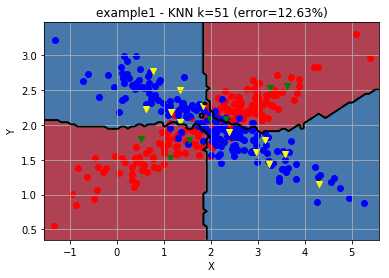

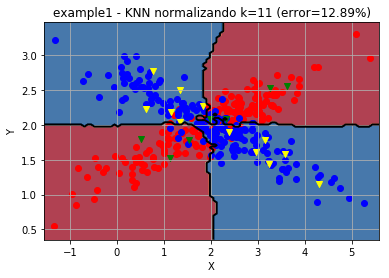

In [17]:
# Plot example 1
example = 0
k = vecinos[np.argmin(errores_medios[example,:,1])]
k_normaliza = vecinos[np.argmin(errores_medios[example,:,0])]
error = np.min(errores_medios[example,:,1])
error_normaliza = np.min(errores_medios[example,:,0])
dibujar_fronteras_knn(datasets[example], dataset_names[example], k, k_normaliza, error, error_normaliza)

En el dataset `example2` se obtiene una clasificación perfecta, no fallando en ninguna de las predicciones. Por eso, el error en ambos casos, tanto normalizando como sin normalizar, es del 0%. Los ejemplos representados en el espacio ocupan zonas disjuntas, con lo que no hay lugares en los que ambas poblaciones se solapen, no pudiendo dar opción al error con vecinos próximos.

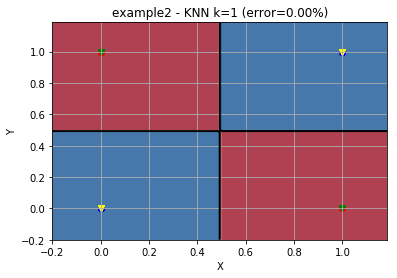

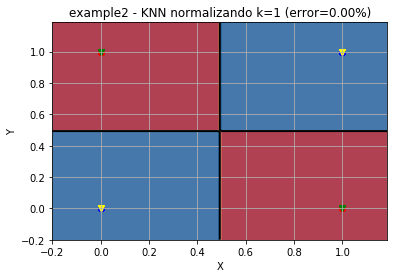

In [18]:
# Plot example 2
example = 1
k = vecinos[np.argmin(errores_medios[example,:,1])]
k_normaliza = vecinos[np.argmin(errores_medios[example,:,0])]
error = np.min(errores_medios[example,:,1])
error_normaliza = np.min(errores_medios[example,:,0])
dibujar_fronteras_knn(datasets[example], dataset_names[example], k, k_normaliza, error, error_normaliza)

En el dataset `example3`, de nuevo obtenemos una población parecida al ejemplo 2, solo que en vez de ocupar un punto dentro de cada cuadrante, se ocupe todo el espacio del propio cuadrante. Es por ello que en la zona de intersección de los 4 cuadrantes, cerca del origen de coordenadas, es difícil clasificar con total precisión la clase del elemento.

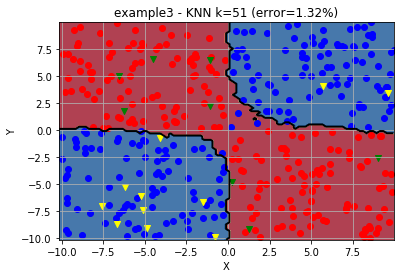

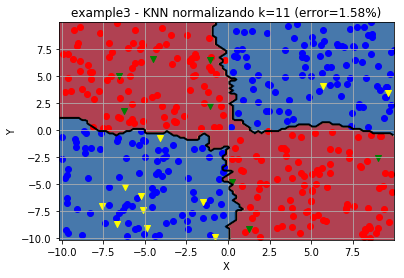

In [19]:
# Plot example 3
example = 2
k = vecinos[np.argmin(errores_medios[example,:,1])]
k_normaliza = vecinos[np.argmin(errores_medios[example,:,0])]
error = np.min(errores_medios[example,:,1])
error_normaliza = np.min(errores_medios[example,:,0])
dibujar_fronteras_knn(datasets[example], dataset_names[example], k, k_normaliza, error, error_normaliza)

En el dataset `example4` sí que observamos una gran diferencia entre normalizar y no normalizar. Si atendemos a las unidades en las que aparecen representados los ejes de las gráficas, vemos que las unidades de las x y de las y difieren en un orden de magnitud de 10. Es por esto que en el caso sin normalización la frontera de decisión no es una línea entre ambas poblaciones, como podría esperarse atendiendo a las poblaciones de ambos ejemplos, sino que presenta picos continuos debido a que el eje x tiene un peso mayor. Sin embargo, si observamos el ejemplo normalizado, vemos que ambas poblaciones se encuentran claramente diferenciadas por una línea casi recta que las separa, minimizando el error.

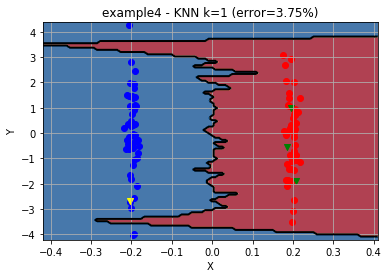

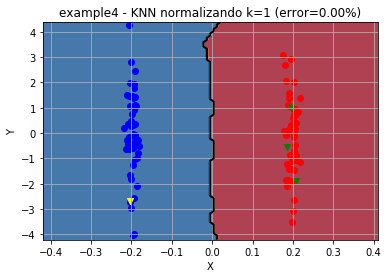

In [20]:
# Plot example 4
example = 3
k = vecinos[np.argmin(errores_medios[example,:,1])]
k_normaliza = vecinos[np.argmin(errores_medios[example,:,0])]
error = np.min(errores_medios[example,:,1])
error_normaliza = np.min(errores_medios[example,:,0])
dibujar_fronteras_knn(datasets[example], dataset_names[example], k, k_normaliza, error, error_normaliza)

Para el conjunto de datos `wdbc` hemos representado su curva ROC asociada, para poder visualizar la bondad del clasificador knn con este conjunto de datos.

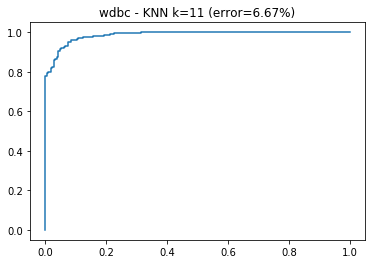

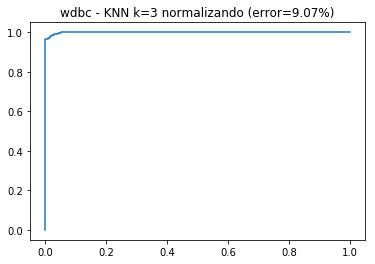

In [63]:
example = 4
k = vecinos[np.argmin(errores_medios[example,:,1])]
k_normaliza = vecinos[np.argmin(errores_medios[example,:,0])]
error = np.min(errores_medios[example,:,1])
error_normaliza = np.min(errores_medios[example,:,0])

dataset = datasets[example]
particion = kfold(dataset)[0]
idx_test = particion.indicesTest
idx_train = particion.indicesTrain
x = dataset[:,0]
y = dataset[:,1]
clase = dataset[:,-1]

# Knn sin normalizar
knn = ClasificadorVecinosProximos(k=k, normaliza=False)
knn.entrenamiento(dataset, indices=particion.indicesTrain)
    
curva_roc(knn, dataset)
plt.title("{} - KNN k={} (error={:.2f}%)".format("wdbc",k, 100*float(error)))
plt.show()

# Knn sin normalizar
knn = ClasificadorVecinosProximos(k=k_normaliza, normaliza=True)
knn.entrenamiento(dataset, indices=particion.indicesTrain)
    
curva_roc(knn, dataset)
plt.title("{} - KNN k={} normalizando (error={:.2f}%)".format("wdbc",k_normaliza, 100*float(error_normaliza)))
plt.show()

A continuación presentamos los resultados obtenidos con la herramienta Sklearn para los resultados sin normalizar. Hemos utilizado, para cada dataset, el k óptimo calculado con anterioridad. Comparándolos podemos ver que son parejos, no hay grandes diferencias.

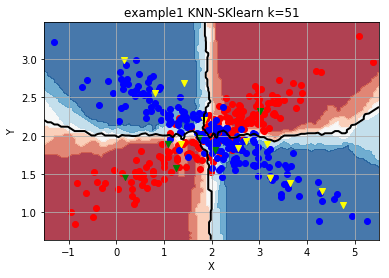

Aciertos utilizando validación:  88.25 %


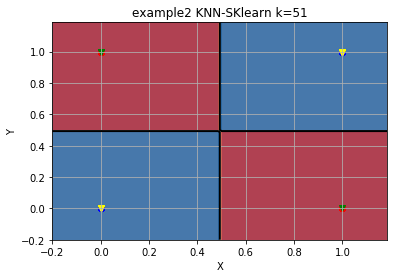

Aciertos utilizando validación:  100.0 %


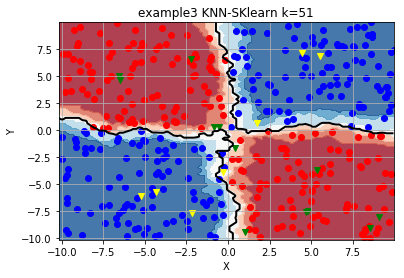

Aciertos utilizando validación:  98.5 %


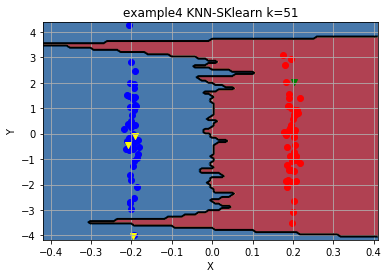

Aciertos utilizando validación:  100.0 %


In [9]:
for i, name in enumerate(dataset_names[:-1]):
    particion = kfold(datasets[i])[0]
    idx = particion.indicesTest
    idx_train = particion.indicesTrain
    knnSklearn = KNeighborsClassifier(n_neighbors=vecinos[np.argmin(errores_medios[i,:,1])])
    knnSklearn.fit(datasets[i][idx_train,:-1], datasets[i][idx_train,-1])
    title = "{} KNN-SKlearn k={}".format(name, k)
    plotModel(datasets[i][idx_train,0],datasets[i][idx_train,1], datasets[i][idx_train,2], 
              knnSklearn, title, datasets[i].diccionarios)
    x = datasets[i][:,0]
    y = datasets[i][:,1]
    clase = datasets[i][:,-1]
    plt.scatter(x[idx][clase[idx]==0], y[idx][clase[idx]==0], c='green', marker="v")
    plt.scatter(x[idx][clase[idx]==1], y[idx][clase[idx]==1], c='yellow', marker="v")    
    
    plt.show()
    print("Aciertos utilizando validación: ",100*knnSklearn.score(datasets[i][:,:-1],datasets[i][:,-1]),"%")


A continuación comprobaremos como varían los resultados ponderando los vecinos inversamente proporcional a su distancia ya normalizada. Podemos observar como cambian las fronteras de decisión, al igual que los errores obtenidos.

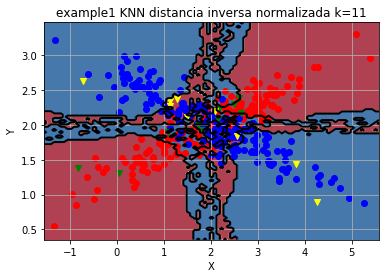

Error utilizando validación:  32.631578947368425 %


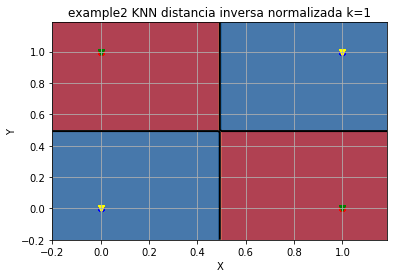

Error utilizando validación:  0.0 %


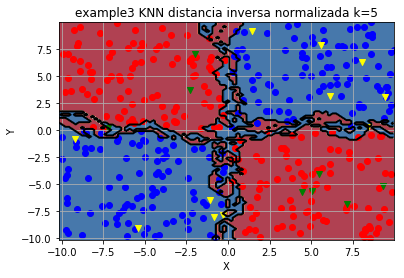

Error utilizando validación:  7.8947368421052655 %


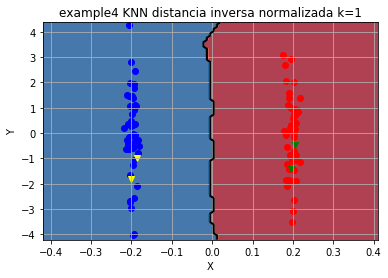

Error utilizando validación:  0.0 %


In [4]:
for i, name in enumerate(dataset_names[:-1]):
    particion = kfold(datasets[i])[0]
    idx = particion.indicesTest
    idx_train = particion.indicesTrain
    k = vecinos[np.argmin(errores_medios[i,:,0])]
    
    knn = ClasificadorVecinosProximos(k=k, normaliza=True, weight='distance')
    knn.entrenamiento(datasets[i], indices=particion.indicesTrain)    
    
    title = "{} KNN distancia inversa normalizada k={}".format(name, k)
    plotModel(datasets[i][idx_train,0],datasets[i][idx_train,1], datasets[i][idx_train,2], 
              knn, title, datasets[i].diccionarios)
    x = datasets[i][:,0]
    y = datasets[i][:,1]
    clase = datasets[i][:,-1]
    plt.scatter(x[idx][clase[idx]==0], y[idx][clase[idx]==0], c='green', marker="v")
    plt.scatter(x[idx][clase[idx]==1], y[idx][clase[idx]==1], c='yellow', marker="v")    
    error = np.mean(Clasificador.validacion(kfold, datasets[i], knn))
    plt.show()
    print("Error utilizando validación: ",100*error,"%")

### Apartado 2 y 3.2 - Regresión Logística


En primer lugar calcularemos cual es el mejor numero de épocas y la mejor constante de aprendizaje para minimizar el error cometido en la clasificación, utilizando para ello validación cruzada.

Después mostraremos las fronteras obtenidas para cada una de las epocas con los mejores parámetros

In [5]:
epochs = (50, 100, 250, 400)
learn_rates = (.001, .1, .5, 1.)
kfold = ValidacionCruzada(20) # Validacion cruzada con 20 k-folds

# Matriz para guardar los errores
errores_medios = np.zeros((len(datasets), len(epochs), len(epochs)))


for i, dataset in enumerate(datasets):    
    for j, epoch in enumerate(epochs):
        for l, learn_rate in enumerate(learn_rates):
            log = ClasificadorRegresionLogistica(epoch=epoch, learn_rate=learn_rate)
            errores = Clasificador.validacion(kfold, dataset, log)
            errores_medios[i, j, l] = np.mean(errores)


A continuación presentamos los errores medios calculados para cada una de las constantes de aprendizaje, y para cada una de las épocas.

In [15]:
for i, name in enumerate(dataset_names):
    print(name)
    print("Epocas / Learn Rates")
    print(errores_medios[i], end="\n\n")

example1
Epocas / Learn Rates
[[0.56842105 0.45263158 0.51842105 0.48947368]
 [0.58421053 0.48947368 0.52105263 0.48421053]
 [0.52631579 0.51842105 0.47894737 0.49210526]
 [0.5        0.4        0.51052632 0.49736842]]

example2
Epocas / Learn Rates
[[0.59473684 0.5        0.52368421 0.46052632]
 [0.65789474 0.47105263 0.51315789 0.55      ]
 [0.65263158 0.56842105 0.35263158 0.50526316]
 [0.68947368 0.35789474 0.51578947 0.50789474]]

example3
Epocas / Learn Rates
[[0.53157895 0.51842105 0.47631579 0.51842105]
 [0.5        0.52105263 0.51315789 0.45526316]
 [0.48421053 0.54736842 0.48947368 0.49473684]
 [0.50263158 0.47368421 0.52368421 0.50263158]]

example4
Epocas / Learn Rates
[[0.5125 0.     0.     0.    ]
 [0.0875 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

wdbc
Epocas / Learn Rates
[[0.12592593 0.12777778 0.12962963 0.15555556]
 [0.09074074 0.13148148 0.1462963  0.08333333]
 [0.12407407 0.10555556 0.09444444 0.22222222]
 [0.25555556 0.06

Al igual que para el caso de vecinos próximos, hemos creado una función para facilitar el dibujo de las fronteras de clasificación. Hemos diferenciado los datos de test y train de ambas poblaciones, representando con un triángulo verde o amarillo a los individuos de test, y con un círculo rojo o azul a los individuos de train. Para cada representación indicamos la época y la constante de aprendizaje utilizadas, y el error obtenido.

In [48]:
def dibujar_fronteras_log(dataset, dataset_name, learn_rate, epoch, error):

    particion = kfold(dataset)[0]
    idx_test = particion.indicesTest
    idx_train = particion.indicesTrain
    
    x = dataset[:,0]
    y = dataset[:,1]
    clase = dataset[:,-1]
    
    log = ClasificadorRegresionLogistica(epoch=epoch, learn_rate=learn_rate)
    log.entrenamiento(dataset, indices=idx_train)
    
    title = "{} - regresión logística epoch={}, $\\eta={}$ (error={:.2f}%)".format(
        dataset_name,epoch, learn_rate, 100*error)
    
    plotModel(x[idx_train], y[idx_train], clase[idx_train], log, title, dataset.diccionarios)
    
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='green', marker="v")
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='yellow', marker="v")
    
    plt.show()

Con el dataset `example1`, al igual que pasará con los dos siguientes, no es un problema separable linealmente. Por ello el porcentaje de error es bastante alto, en ocasiones cercano al 50%.

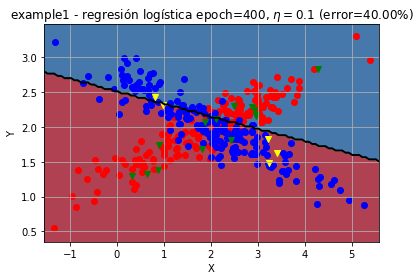

In [51]:
# Plot example 1
example = 0
errores = errores_medios[example]
i, j = np.argmin(errores)// errores.shape[0], np.argmin(errores) % errores.shape[0]
epoch = epochs[i]
learn_rate = learn_rates[j]
error = errores_medios[example, i, j]

dibujar_fronteras_log(datasets[example], dataset_names[example], learn_rate, epoch, error)

Con el dataset `example2` el análisis es análogo al ejemplo anterior.

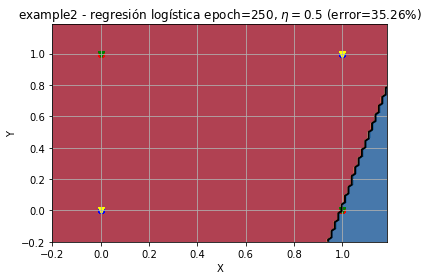

In [54]:
# Plot example 2
example = 1
errores = errores_medios[example]
i, j = np.argmin(errores)// errores.shape[0], np.argmin(errores) % errores.shape[0]
epoch = epochs[i]
learn_rate = learn_rates[j]
error = errores_medios[example, i, j]

dibujar_fronteras_log(datasets[example], dataset_names[example], learn_rate, epoch, error)

Con el dataset `example3` de nuevo tenemos el mismo problema que con los dos anteriores,y por ello el error queda cercano al 50%.

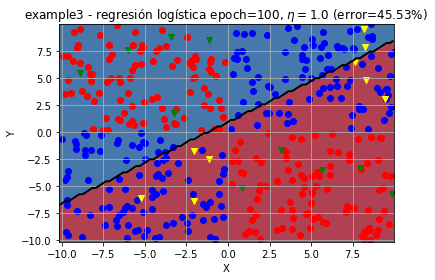

In [55]:
# Plot example 3
example = 2
errores = errores_medios[example]
i, j = np.argmin(errores)// errores.shape[0], np.argmin(errores) % errores.shape[0]
epoch = epochs[i]
learn_rate = learn_rates[j]
error = errores_medios[example, i, j]

dibujar_fronteras_log(datasets[example], dataset_names[example], learn_rate, epoch, error)

El dataset `example4` es el único que podemos separar linealmente, debido a que las dos poblaciones son claramente diferenciables.

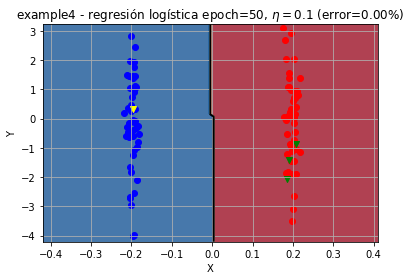

In [57]:
# Plot example 4
example = 3
errores = errores_medios[example]
i, j = np.argmin(errores)// errores.shape[0], np.argmin(errores) % errores.shape[0]
epoch = epochs[i]
learn_rate = learn_rates[j]
error = errores_medios[example, i, j]

dibujar_fronteras_log(datasets[example], dataset_names[example], learn_rate, epoch, error)

A continuación presentamos los resultados obtenidos con la herramienta Sklearn. No hemos especificado ni el número de épocas ni la constante de aprendizaje, ya que sklearn utiliza otro optimizador. Obtenemos, no obstante, similares resultados, o mejores en algún caso.

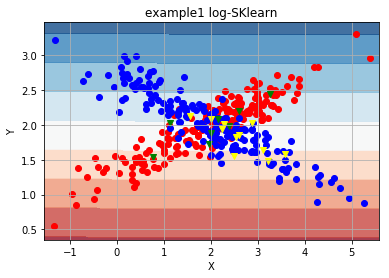

Error utilizando validacion:  54.5 %


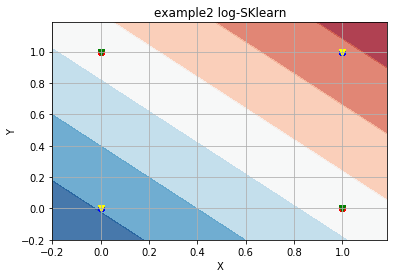

Error utilizando validacion:  50.0 %


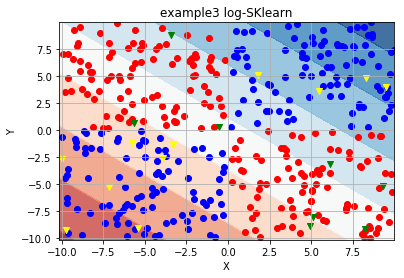

Error utilizando validacion:  43.25 %


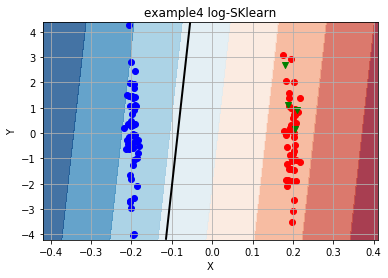

Error utilizando validacion:  0.0 %


In [6]:
for i, name in enumerate(dataset_names[:-1]):
    particion = kfold(datasets[i])[0]
    idx_test = particion.indicesTest
    idx_train = particion.indicesTrain
    logSklearn = LogisticRegression()
    
    logSklearn.fit(datasets[i][idx_train,:-1], datasets[i][idx_train,-1])
    title = "{} log-SKlearn".format(name)
    
    
    x = datasets[i][:,0]
    y = datasets[i][:,1]
    clase = datasets[i][:,-1]
    
    plotModel(datasets[i][idx_train,0],datasets[i][idx_train,1], datasets[i][idx_train,2], logSklearn, title, datasets[i].diccionarios)
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='green', marker="v")
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='yellow', marker="v")
    plt.show()
    
    print("Error utilizando validacion: ",100 -100*logSklearn.score(datasets[i][:,:-1],datasets[i][:,-1]),"%")
